In [1]:
# !pip install torch
# !pip install torchvision
# !pip install torchaudio
# !pip install scikit-learn
# !pip install matplotlib
# !pip install pandas
# !pip install seaborn
# !pip install numpy

In [2]:
# imports relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import datetime
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
# loading dataset from our public github
url = 'https://raw.githubusercontent.com/Thomas101Shen/Dynamic_hedging/refs/heads/main/Option_SPX.csv'
data = pd.read_csv(url)
data = data

# printing dataset information and dropping NA rows
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
print(data.head())

# Taking a subset of features (Moneyness, Time to Maturity, and Black Scholes Delta)
X = data[['Moneyness', 'TTM', 'D_BS']]
# Setting our target variable
y = data[['Target']]

# printing stats on the independent variables in our dataset
print(f'\n\nFeatures:\n {X.describe()} \n\n\n Test data:\n {y.describe()}')

(1008, 14)
(1008, 14)
         Date  ID  Days until next hedge        S  Dividend        C_BS  \
0  2024-10-09   1                      1  5792.04    1.3255  347.319191   
1  2024-08-12   3                      1  5344.39    1.4375   65.911689   
2  2024-08-05   5                      1  5186.33    1.4816   29.540325   
3  2024-11-15   1                      3  5870.62    1.3163  351.552064   
4  2024-09-17   6                      1  5634.58    1.3645   46.314393   

       D_BS   C_mkt  D_Blm        R  TTM  Moneyness  D_Optimal    Target  
0  0.630024  357.80  0.642  4.78852  163      92.04   0.385249 -0.244775  
1  0.227086   74.05  0.247  4.96403  221    -555.61   0.228776  0.001690  
2  0.111161   38.45  0.132  4.95853  228    -913.67  -0.159851 -0.271012  
3  0.685499  370.40  0.710  4.77039  126     170.62   0.377866 -0.307633  
4  0.185447   54.15  0.208  4.76338  185    -565.42   0.160314 -0.025133  


Features:
          Moneyness          TTM         D_BS
count  1008.000000 

         Moneyness          TTM         D_BS
count  1008.000000  1008.000000  1008.000000
mean   -235.458214   124.095238     0.376424
std     262.068916    57.098591     0.203848
min   -1013.670000    18.000000     0.029593
25%    -403.175000    78.750000     0.208732
50%    -218.595000   124.500000     0.364226
75%     -52.537500   169.250000     0.524479
max     347.150000   228.000000     0.948629

Skew: 
Moneyness   -0.234378
TTM          0.003353
D_BS         0.337676
dtype: float64

Kurtosis: 
Moneyness   -0.237599
TTM         -0.964705
D_BS        -0.646047
dtype: float64


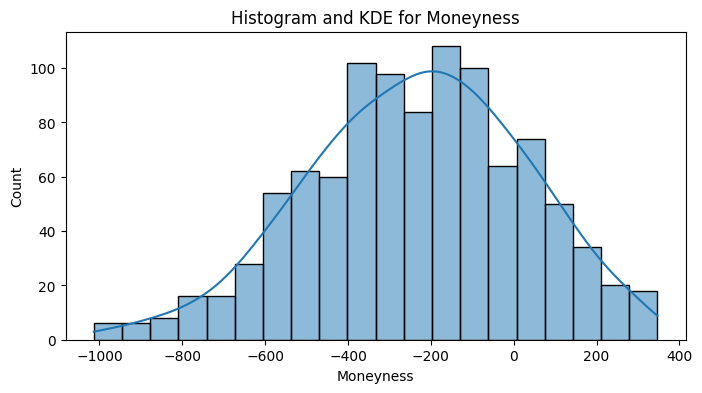

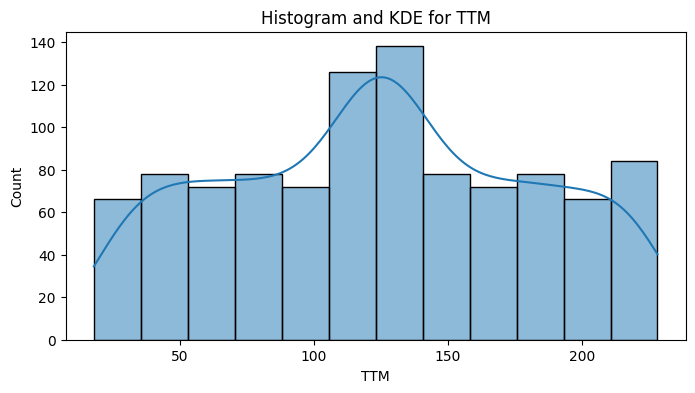

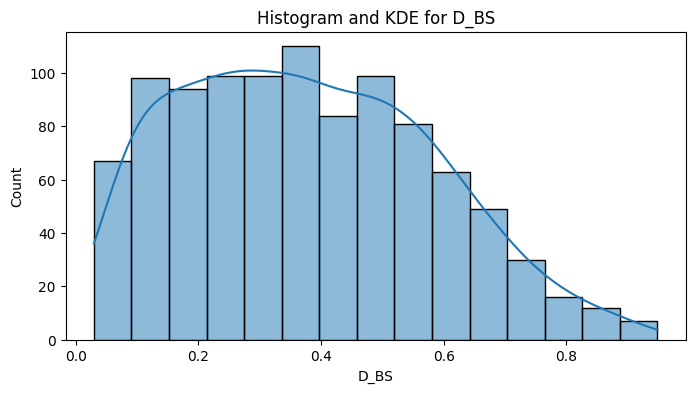

            Target
count  1008.000000
mean     -0.254678
std       3.233856
min     -40.533411
25%      -0.123975
50%      -0.033288
75%       0.067694
max       8.216118

Skew: 
Target   -8.577093
dtype: float64

Kurtosis: 
Target    84.230278
dtype: float64


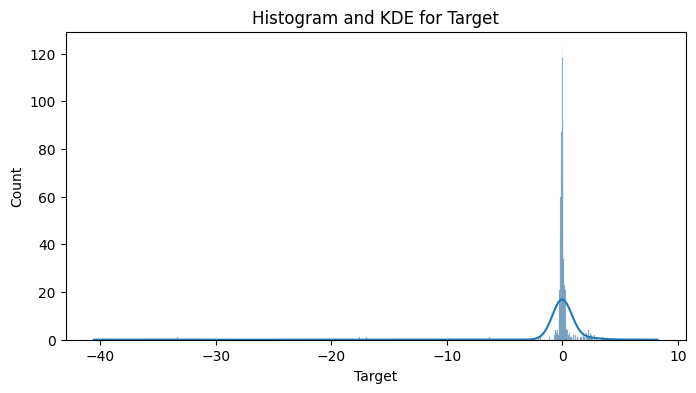

In [4]:
# This function prints statistics on the variables of a dataset
# It also creates histograms and KDEs of these variables
def describe_data(df):
    print(df.describe())
    print("\nSkew: ")
    print(df.skew())
    print("\nKurtosis: ")
    print(df.kurtosis())
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Histogram and KDE for {column}')
        plt.show()

# Uses the above function for our independent variables
describe_data(X)
# Uses the above function for our target variable
describe_data(y)

In [5]:
# Randomly splits our dataset cross-sectionally (80:20 split) into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [6]:
# Randomly splits our train_val data cross-sectionally (80:20 split) into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=True)

In [7]:
# this function plots the histograms of the feature distributions of training and testing sets
def plot_train_test(train, test):
    columns = train.columns.tolist()
    # print(train.min(), test.min(), train.max(), test.max())
    for column in columns:
        plt.hist(train[column], bins=30, alpha=0.5
                 , label=f'Training data for {column}')
        plt.hist(test[column], bins=30, alpha=0.5, label=f'Test data for {column}')
        plt.legend()
        plt.title(f'Distribution of {column}')
        plt.show()

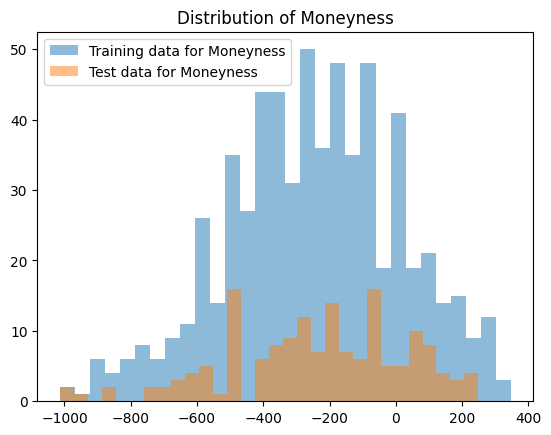

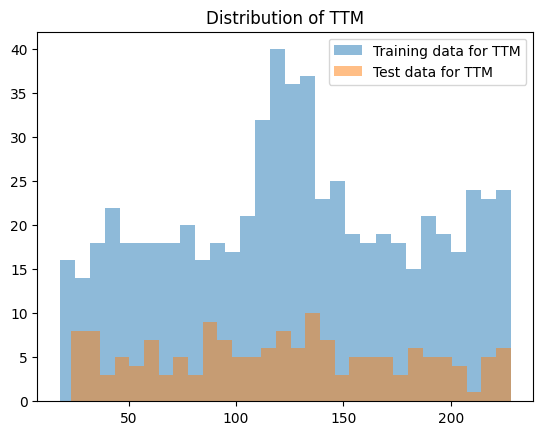

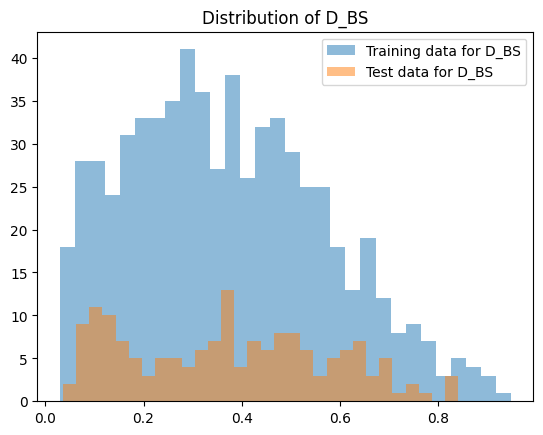

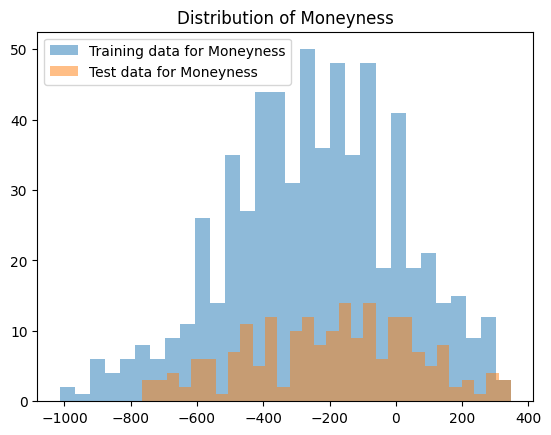

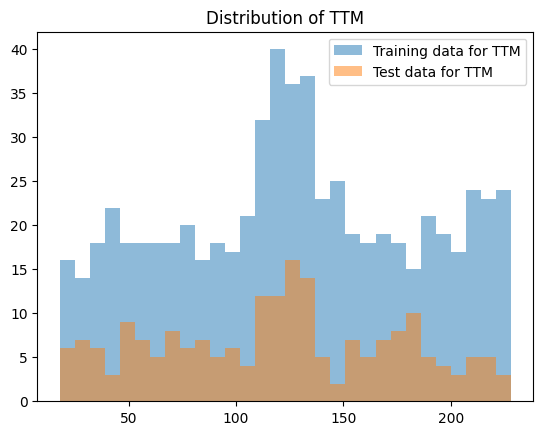

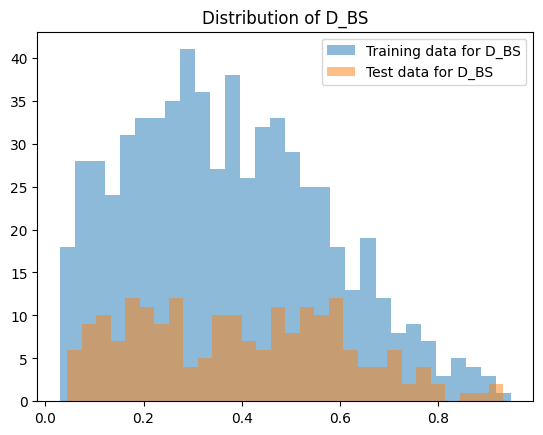

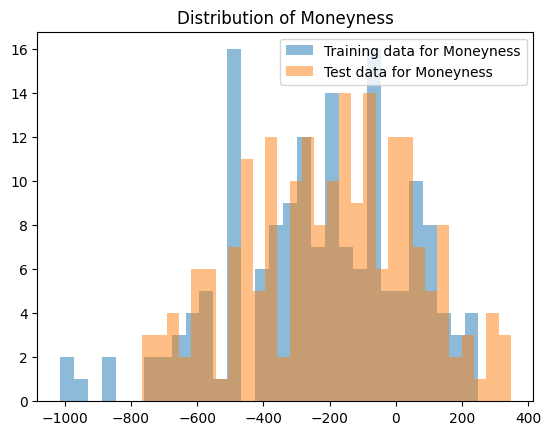

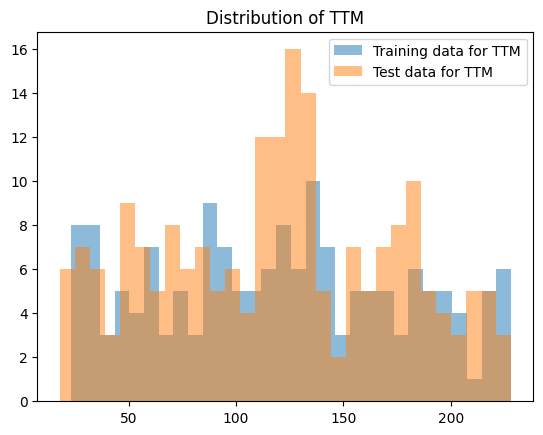

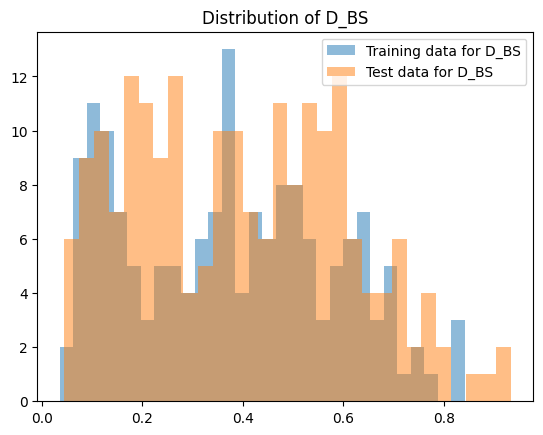

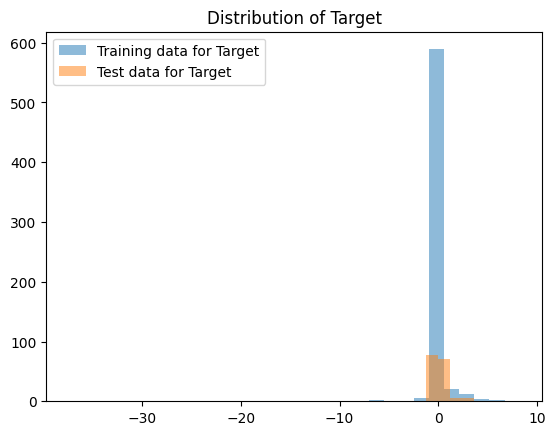

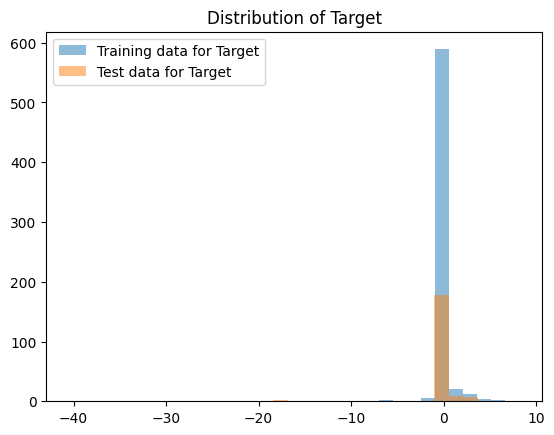

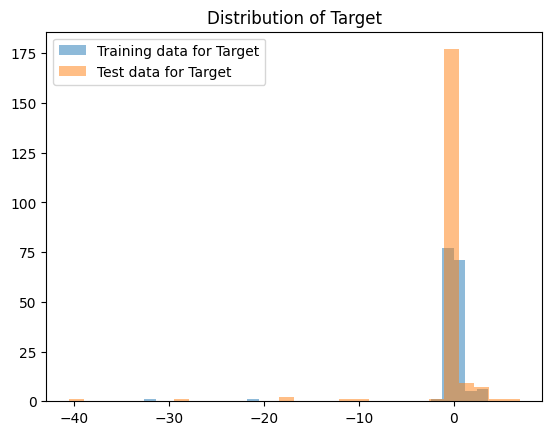

In [8]:
# plots feature histograms below
plot_train_test(X_train, X_val)
print("\n\n\n\n\n\n")
plot_train_test(X_train, X_test)
print("\n\n\n\n\n\n")
plot_train_test(X_val, X_test)  # Make note this is comparing the val to test
print("\n\n\n\n\n\n")

# plots histograms below (for target variable)
plot_train_test(y_train, y_val)
print("\n\n\n\n\n\n")
plot_train_test(y_train, y_test)
print("\n\n\n\n\n\n")
plot_train_test(y_val, y_test)  # Make note this is comparing the val to test

In [9]:
# We use a MinMaxScaler and fit it using our training data
scaler = MinMaxScaler()
scaler.fit(X_train)

feat_cols = ['Moneyness', 'TTM', 'D_BS']

import torch
from sklearn.preprocessing import MinMaxScaler

def scale_feat(scaler, *features):
    """
    Scales the input features using a provided scaler and converts them to PyTorch tensors.

    Parameters:
    - scaler: A fitted scaler instance (e.g., MinMaxScaler).
    - *features: Variable-length list of pandas DataFrames to scale and convert.

    Returns:
    - A tuple of pd dataframes or single pd dataframe corresponding to the scaled input features.
    """
    scaled_features = []
    for feature in features:
        # Ensure the feature is scaled
        feat_cols = feature.columns
        scaled_feature = scaler.transform(feature)
        scaled_feature = pd.DataFrame(scaled_feature, columns=feat_cols)
        scaled_features.append(scaled_feature)
    return tuple(scaled_features) if len(scaled_features) > 1 else scaled_features[0]

def convert_tensor(*inputs):
    """
    converts inputs to PyTorch tensors.

    Parameters:
    - *features: Variable-length list of pandas DataFrames to convert.

    Returns:
    - A tuple of PyTorch tensors or single tensor corresponding to the scaled input features.
    """
    tensors = []
    for inpt in inputs:
        tensor = torch.tensor(inpt.values, dtype=torch.float32)
        tensors.append(tensor)

    return tuple(tensors) if len(tensors) > 1 else tensors[0] # Convert list to tuple before returning

X_train, X_val, X_test = scale_feat(scaler, X_train, X_val, X_test)

In [10]:
# converts X data into PyTorch tensors using function defined above
X_train, X_val, X_test = convert_tensor(X_train, X_val, X_test)

In [11]:
# converts y data into PyTorch tensors using function defined above
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)
y_val = torch.tensor(y_val.values, dtype=torch.float)

In [12]:
# Defining the architecture of our PyTorch feed-forward neural network

import torch.nn as nn
import torch.optim as optim

class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

input_size = 3
hidden_size = 6
output_size = 1

In [13]:
# sets our model object (PyTorch FNN defined above), loss function (MSE), and optimizer (Adam optimizer w/ learning-rate of 0.01)
model = FNN(input_size, hidden_size, output_size)
loss_func = nn.MSELoss()
optimizer_mse = optim.Adam(model.parameters(), lr=0.01)

In [14]:
def train_model(model, epochs, loss_fun, optimizer):
    patience = 20
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        # Forward pass
        predictions_train = model(X_train)
        loss_train = loss_func(predictions_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            predictions_val = model(X_val)
            loss_val = loss_func(predictions_val, y_val)

        # Check for improvement and triggers early stoppage if conditions are met
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stoppage")
                print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")
                break

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

In [15]:
# Trains our neural network model over 1000 epochs, no batching
train_model(model, 1000, loss_func, optimizer_mse)

Epoch [5/1000], Training Loss: 8.6703, Validation Loss: 9.6449
Epoch [10/1000], Training Loss: 8.6544, Validation Loss: 9.6316
Epoch [15/1000], Training Loss: 8.6504, Validation Loss: 9.6330
Epoch [20/1000], Training Loss: 8.6444, Validation Loss: 9.6294
Epoch [25/1000], Training Loss: 8.6407, Validation Loss: 9.6253
Epoch [30/1000], Training Loss: 8.6366, Validation Loss: 9.6197
Epoch [35/1000], Training Loss: 8.6310, Validation Loss: 9.6124
Epoch [40/1000], Training Loss: 8.6262, Validation Loss: 9.6041
Epoch [45/1000], Training Loss: 8.6207, Validation Loss: 9.6004
Epoch [50/1000], Training Loss: 8.6164, Validation Loss: 9.5937
Epoch [55/1000], Training Loss: 8.6122, Validation Loss: 9.5834
Epoch [60/1000], Training Loss: 8.6085, Validation Loss: 9.5760
Epoch [65/1000], Training Loss: 8.6057, Validation Loss: 9.5717
Epoch [70/1000], Training Loss: 8.6036, Validation Loss: 9.5687
Epoch [75/1000], Training Loss: 8.6026, Validation Loss: 9.5721
Epoch [80/1000], Training Loss: 8.6018, V

In [18]:
# defines the same training function as before but with batches
def train_batch_model(model, epochs, batch_size, loss_func, optimizer):
    patience = 20
    wait = 0
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        for start in range(0, len(X_train), batch_size):
            end = start + batch_size
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]

            # Forward pass
            predictions_train = model(X_batch)
            loss_train = loss_func(predictions_train, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            predictions_val = model(X_val)
            loss_val = loss_func(predictions_val, y_val)

        # Check for improvement and trigger early stoppage if conditions are met
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stoppage")
                print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")
                break

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

In [19]:
# Creates a new neural network variable for a model that uses batching
batch_model = FNN(input_size, hidden_size, output_size)
optimizer_mse_batch = optim.Adam(batch_model.parameters(), lr=0.01)

In [20]:
# trains the batched model over 1000 epochs using a batch size of 32
train_batch_model(batch_model, 1000, 30, loss_func, optimizer_mse_batch)

Epoch [5/1000], Training Loss: 0.0260, Validation Loss: 9.6575
Epoch [10/1000], Training Loss: 0.0223, Validation Loss: 9.6437
Epoch [15/1000], Training Loss: 0.0202, Validation Loss: 9.6345
Epoch [20/1000], Training Loss: 0.0234, Validation Loss: 9.6007
Epoch [25/1000], Training Loss: 0.0290, Validation Loss: 9.5793
Epoch [30/1000], Training Loss: 0.0351, Validation Loss: 9.5805
Epoch [35/1000], Training Loss: 0.0377, Validation Loss: 9.5780
Epoch [40/1000], Training Loss: 0.0408, Validation Loss: 9.5765
Epoch [45/1000], Training Loss: 0.0431, Validation Loss: 9.5816
Epoch [50/1000], Training Loss: 0.0423, Validation Loss: 9.5772
Epoch [55/1000], Training Loss: 0.0428, Validation Loss: 9.5715
Epoch [60/1000], Training Loss: 0.0422, Validation Loss: 9.5728
Early stoppage
Epoch [61/1000], Training Loss: 0.0437, Validation Loss: 9.5752


In [21]:
# Defines a new PyTorch neural network object, now with batch normalization
class FNN_batch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN_batch, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.output(x)
        return x


# input_size = 3
# hidden_size = 6
# output_size = 1

In [22]:
# Creates a new neural network variable that uses batching normalization
batch_norm_model = FNN_batch(input_size, hidden_size, output_size)
optimizer_batch_norm = optim.Adam(batch_model.parameters(), lr=0.01)

# Trains the batch normalization model over 1000 epochs with a batch size of 30
train_batch_model(batch_model, 1000, 30, loss_func, optimizer_batch_norm)

Epoch [5/1000], Training Loss: 0.0422, Validation Loss: 9.5811
Epoch [10/1000], Training Loss: 0.0421, Validation Loss: 9.5777
Epoch [15/1000], Training Loss: 0.0373, Validation Loss: 9.5714
Epoch [20/1000], Training Loss: 0.0330, Validation Loss: 9.5924
Epoch [25/1000], Training Loss: 0.0350, Validation Loss: 9.5742
Epoch [30/1000], Training Loss: 0.0451, Validation Loss: 9.5670
Epoch [35/1000], Training Loss: 0.0291, Validation Loss: 9.5800
Epoch [40/1000], Training Loss: 0.0332, Validation Loss: 9.5653
Epoch [45/1000], Training Loss: 0.0311, Validation Loss: 9.5835
Epoch [50/1000], Training Loss: 0.0298, Validation Loss: 9.5739
Epoch [55/1000], Training Loss: 0.0354, Validation Loss: 9.6028
Early stoppage
Epoch [57/1000], Training Loss: 0.0239, Validation Loss: 9.5911


In [23]:
# evaluates the three previous models and the non-ML Black Scholes Delta (using MSE)
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = loss_func(predictions, y_test)
    print(f"No batch MSE: {test_loss.item():.4f}")

batch_model.eval()
with torch.no_grad():
    predictions = batch_model(X_test)
    test_loss = loss_func(predictions, y_test)
    print(f"30 batch MSE: {test_loss.item():.4f}")

batch_norm_model.eval()
with torch.no_grad():
    predictions = batch_norm_model(X_test)
    test_loss = loss_func(predictions, y_test)
    print(f"30 batch norm MSE: {test_loss.item():.4f}")

mse_greeks = (data['Target']**2).mean()
print(f"Standard greek MSE: {mse_greeks}")

No batch MSE: 16.7315
30 batch MSE: 16.8237
30 batch norm MSE: 16.8102
Standard greek MSE: 10.51231005280044
